# **Installing the enviroment**

In [1]:
# !pip install pyLDAvis
# !pip install nltk
# !pip install --upgrade numpy
# !pip install numpy==1.23.3

# **Importing the necessary libraries**

In [2]:
import re
import nltk
import random
import pandas as pd
import numpy as np
from urllib import request
from nltk import pos_tag
from nltk.corpus import gutenberg, stopwords, wordnet
from nltk.tokenize import regexp_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from wordcloud import wordcloud
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.text import TSNEVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from pprint import pprint

from sklearn.metrics import cohen_kappa_score
from sklearn.cluster import KMeans

from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
#--
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.preprocessing import LabelEncoder
# import pyLDAvis.gensim

import os
import multiprocessing
import gensim
from gensim import corpora
from gensim.models import LdaModel
os.environ["OMP_NUM_THREADS"] = str(multiprocessing.cpu_count())
import warnings
warnings.filterwarnings('ignore')

# **Defining our functions**

In [3]:
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## **get_word_net_pos( )**

In [4]:
def get_word_net_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else :
        return wordnet.NOUN

## **read_book( )**

It Takes 3 parameters the URL of the Book, the Name of the book and the number of words for each book partition

It Reads the Book, Decode, lower the Characters, Remove the Unnecessary characters, Remove the Stopwords, and Tokenize them

It Gets 200 Random Samples each Consists of "word_num" Words

Then, Using the Previous "get_word_net_pos" Function we lemmatize the Tokens and Label the Book with its Author's name

Finally, We Return the Dataframe

In [5]:
def read_book(url,name , word_num) :
    lemmatizer = WordNetLemmatizer()
    response = request.urlopen(url)
    lines = (response.read().decode('utf8')).lower()
    book = regexp_tokenize(lines,r'([a-zA-Z]{3,})[\,|\s|\.]') # words that are at least three characters long. It considers a word to end when it encounters either a comma, a whitespace character, or a period.
    tokens = [token for token in book if token.lower() not in stop_words]
    books =[]
    for i in range(200) :
        start = random.randint(0 , len(tokens) - word_num)
        books.append([' '.join(tokens[start: start + word_num])])
    df = pd.DataFrame(books, columns=["partitions"])
    for i in range(200):
        sent=""
        x = nltk.pos_tag((df.partitions[i]).split())
        for word,tag in x:
            lemma = lemmatizer.lemmatize(word,pos=get_word_net_pos(tag))
            sent += lemma+" "
            df.partitions[i] = sent
    df["author"] = name
    return df

## **five_books( )**

It Takes the List of URLs of the Books, the Authors List and the number of words for each partition as parameters
For each URL it Reads the Book and Preprocess it as Above then Append all of the Dataframes into a Full Dataframe that Contains all the Books Samples


In [6]:
def five_books(list_of_urls,author_list , word_num) :
    df_full = pd.DataFrame()
    for i,j in enumerate(list_of_urls) :
        df = read_book(j,author_list[i] , word_num)
        df_full = pd.concat([df_full, df], ignore_index=True)
    return df_full

## **get_most_repeated_words( )**

**To Display the most Repeated n Words**

In [7]:
def get_most_repeated_words(text, n):
    words = []
    for t in text:
        words.extend(t.lower().split())

    word_counts = Counter(words)
    most_common = word_counts.most_common(n)
    return most_common

## **draw_TSNE( )**

**To Display the Scatter plot for each Book To see the Similarity between these Books**

In [8]:
def draw_TSNE (df_input,label):
    tsne = TSNEVisualizer(title = label)
    tsne.fit(df_input,df["author"])
    tsne.show()

## **draw_chart( )**

**To show the Word Denisty for all Books**

It takes two parameters: the Data frame containing all books and the list of authors names

In [9]:
def draw_chart(all_books, author_list, n=10):
    fig, axes = plt.subplots(nrows=len(author_list), ncols=2, figsize=(15, 6 * len(author_list)))
    plt.subplots_adjust(hspace=0.4)

    for i, author in enumerate(author_list):
        temp = all_books[all_books["author"] == author]["partitions"]

        wc = wordcloud.WordCloud(background_color='black', max_words=200, max_font_size=35)
        wc.generate_from_frequencies(dict(get_most_repeated_words(temp, 100)))

        axes[i, 0].imshow(wc, cmap=None)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Word Cloud - {author}')

        words = []
        for t in temp:
            words.extend(t.lower().split())

        word_counts = Counter(words)
        common_words = word_counts.most_common(n)
        df1 = pd.DataFrame(common_words, columns=['word', 'count'])

        sns.barplot(data=df1, x='word', y='count', ax=axes[i, 1], palette='coolwarm')
        axes[i, 1].set_title('Top {} Words - {}'.format(n, author))
        axes[i, 1].set_xlabel('Word')
        axes[i, 1].set_ylabel('Count')
        axes[i, 1].tick_params(axis='x', rotation=45)

    plt.show()

## **bow( )**

**Convert the Text Dataframe into a Bag of Words Representation Then, Split the BOW Dataframe into Train and Test Sets italicized text**

In [10]:
def bow(df):
    vectorizer = CountVectorizer()
    bow_model = vectorizer.fit(df.partitions)
    X = bow_model.transform(df.partitions)
    df_bow = pd.DataFrame(X.toarray(),columns = bow_model.get_feature_names_out())
    return df_bow

## **tf_idf( )**

**Convert the Text Dataframe into a TF_IDF Representation Then, Split the TF_IDF Dataframe into Train and Test Sets**

In [11]:
def tf_idf(df):
    vectorizer = TfidfVectorizer()
    tf_idf_model = vectorizer.fit(df.partitions)
    tf_idf_out=tf_idf_model.transform(df.partitions)
    feature_names = tf_idf_model.get_feature_names_out()
    dense = tf_idf_out.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)
    return df

## **LDA_Viualization( )**

In [12]:
def LDA_Viualization(df):

    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(df.partitions, min_count=20)
    for idx in range(len(df.partitions)):
        for token in bigram[df.partitions[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                df.partitions[idx].append(token)

    # Create a dictionary representation of the documents.
    tokenized_documents = [nltk.word_tokenize(doc) for doc in df.partitions]

    # Create a dictionary representation of the documents
    dictionary = Dictionary(tokenized_documents)
    # dictionary = Dictionary(df.partitions)

    # Filter out words that occur less than 20 documents, or more than 50% of the documents.
    dictionary.filter_extremes(no_below=20, no_above=0.5)

    corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

    # Set training parameters.
    num_topics = 10
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )
    top_topics = model.top_topics(corpus)

    # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
    avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
    print('Average topic coherence: %.4f.' % avg_topic_coherence)

    pprint(top_topics)
    return corpus,model,dictionary

## **apply_lda( )**

**Apply LDA to a column of data in the DataFrame.**

In [13]:
def apply_lda(df, column, num_topics):

    def preprocess_text(text):
        processed_text = text.split()
        return processed_text

    preprocessed_data = df[column].apply(preprocess_text)
    dictionary = corpora.Dictionary(preprocessed_data)
    corpus = [dictionary.doc2bow(text) for text in preprocessed_data]
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

    document_topics = []
    for doc in corpus:
        topic_dist = lda_model.get_document_topics(doc)
        document_topics.append([topic[1] for topic in topic_dist])
    max_length = max(len(seq) for seq in document_topics)

    padded_sequences = [seq + [0] * (max_length - len(seq)) for seq in document_topics]

    X = np.array(padded_sequences)
    return X

## **map_for_kappa( )**

**We determine the count of values in every 200 records then sort them then change the original labels to the most repeated predicted label**

In [14]:
def map_for_kappa(my_list, old_label):
    count_dict = {
        "0": [],
        "1": [],
        "2": [],
        "3": [],
        "4": []
    }
    assigned_values = set()

    for i in range(0, len(my_list), 200):
        group = my_list[i:i + 200]
        counts = Counter(group)
        for i in range(5):
            count_dict[f'{i}'].append(counts[i])


    max_indices = {}

    for key, value in count_dict.items():
        max_index = None
        for idx, count in enumerate(value):
            if idx not in assigned_values:
                if max_index is None or count > value[max_index]:
                    max_index = idx

        max_indices[key] = max_index
        assigned_values.add(max_index)

    sorted_dict = dict(sorted(max_indices.items(), key=lambda x: x[1]))

    for key, value in sorted_dict.items():
        old_label[value * 200:value * 200 + 200] = [int(key)] * 200

    return old_label


## **get_coherence( )**

**Calculate the coherence score of a model generated using LDA**

In [15]:
def get_coherence(data_bow, df_columnm):
    lda=LatentDirichletAllocation(n_components=5,random_state=0)
    lda.fit(data_bow)
    lda.transform(data_bow)
    topics = lda.components_

    n_top_words = 20
    texts = [[word for word in doc.split()] for doc in df_columnm]

    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    feature_names = [dictionary[i] for i in range(len(dictionary))]

    top_words = []
    for topic in topics:
        top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

    coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence

## **plotting( )**

**compare the scores of models**

In [16]:
def plotting(scores_list , labels_list , title):
  fig,ax = plt.subplots()
  ax.barh(labels_list, scores_list)
  ax.set_xlabel('Silhouette Score')
  ax.set_title(title)
  plt.show()

## **silhouettescore( )**

**calcualte the silhouettes core of each model**

In [17]:
def silhouettescore(X , pred_y ):
    score = silhouette_score(X , pred_y) * 100
    return score


## **multi_km( )**

**display the elbow plot to get the best K**

In [18]:
def multi_km(X):
    wcss = []
    for i in range(2, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
        km_labels = kmeans.predict(X)
        silhouettescore(X,km_labels)
    plt.plot(range(2, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

## **KMEANS( )**

**Perform k-means clustering data and visualize the results using a silhouette plot and scatter plot and display the silhouette score**

In [66]:
def KMEANS(data_bow,num_cluster):
  X_embedded = pca.fit_transform(data_bow)
  km_cls = KMeans(n_clusters=num_cluster, init='k-means++', max_iter=300, n_init=10, random_state=42)
  km_cls.fit(X_embedded)
  km_labels = km_cls.predict(X_embedded)
  score = silhouettescore(X_embedded, km_labels)
  visualizer = SilhouetteVisualizer(km_cls)
  visualizer.fit(X_embedded, km_labels)
  visualizer.poof()
  colors = ["grey","black","blue","cyan","green","yellow","brown","pink"]
  for i in range (num_cluster):
    plt.scatter(X_embedded[km_labels ==i,0], X_embedded[km_labels == i,1], s=100, c=colors[i])
    plt.scatter(km_cls.cluster_centers_[i, 0], km_cls.cluster_centers_[i, 1], s=300, c='red')
  plt.show()
  print("silhouette score : ",score)
  return km_labels , score




## **AGG( )**

**Perform agglomerative clustering on data and visualize the results using a dendrogram and scatter plot**

In [22]:
def AGG(X , clusters_num ):

    X_embedded = pca.fit_transform(data_bow)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    dendrogram = sch.dendrogram(sch.linkage(X_embedded, method = "ward"), ax=ax1)

    hc = AgglomerativeClustering(n_clusters = clusters_num, affinity = 'euclidean', linkage = "ward")
    y_hc = hc.fit_predict(X_embedded)
    score = silhouettescore(X_embedded, y_hc)



    colors = ["red","black","blue","cyan","green"]
    for i in range (5):
      ax2.scatter(X_embedded[y_hc ==i,0], X_embedded[y_hc == i,1], s=100, c=colors[i])

    ax1.set_title('Dendrogram')
    ax2.set_title('Scatter Plot')
    plt.tight_layout()
    plt.show()

    print("silhouette score : ",score)


    return y_hc, score


## **GMM( )**

**Perform GMM on data using a specified number of components and visualize the results using scatter plot and calculate the silhouette score**

In [23]:
def GMM(X,components_num):

    X_embedded = pca.fit_transform(data_bow)
    gmm = GaussianMixture(n_components=components_num,random_state=42,covariance_type='tied',tol=0.001)
    gmm.fit(X_embedded)
    gmm_labels=gmm.predict(X_embedded)
    score = silhouettescore(X_embedded , gmm_labels)
    colors = ["red", "black", "blue", "cyan", "green"]
    for i in range(5):
        plt.scatter(X_embedded[gmm_labels == i, 0], X_embedded[gmm_labels == i, 1], s=100, c=colors[i])

    plt.title('Scatter Plot')
    plt.show()
    print("silhouette score : ",score)

    return gmm_labels , score


## **DBScan( )**

**Perform DBScan on data and visualize the results using scatter plot and calculate the silhoutte score**

In [24]:
def DBScan(X):

    X_embedded = pca.fit_transform(data_bow)
    dbscan = DBSCAN()
    labels = dbscan.fit_predict(X_embedded)
    score = silhouettescore(X_embedded , labels)
    colors = ["red", "black", "blue", "cyan", "green"]

    for i in range(5):
        plt.scatter(X_embedded[labels == i, 0], X_embedded[labels == i, 1], s=100, c=colors[i])

    plt.title('Scatter Plot')
    plt.show()
    print("silhouette score : ",score)

    return labels , score


# **Reading the books**

**Get 5 Books from Gutenberg Library**


*   **The Adventures of Pinocchio by Carlo Collodi**
*   **Les Misérables by Victor Hugo**
*   **Dracula by Bram Stoker**
*   **Thus Spoke Zarathustra by Friedrich Nietzsche**
*   **The Adventures of Sherlock Holmes by Arthur Conan Doyle**



In [25]:
pinocchio = "https://www.gutenberg.org/files/500/500-0.txt"
Les_Misérables = "https://www.gutenberg.org/files/135/135-0.txt"
dracula = "https://www.gutenberg.org/files/345/345-0.txt"
Zarathustra = "https://www.gutenberg.org/files/1998/1998-0.txt"
Sherlock_Holmes = "https://www.gutenberg.org/files/1661/1661-0.txt"
books_list = [pinocchio , Les_Misérables , dracula , Zarathustra , Sherlock_Holmes]
author_list = ["a", "b", "c", "d", "e"]

In [26]:
df = five_books(books_list,author_list, 150)

In [27]:
df

,partitions,author
0,much work look long time say know see bend low...,a
1,wig white curl drop waist wore jaunty coat col...,a
2,pinocchio sell book pay way marionette theater...,a
3,bed little nap say another laughing also answe...,a
4,farmer go house close door bar poor pinocchio ...,a
...,...,...
995,hold lantern gaze say merryweather strike stic...,e
996,right carriage hall fail catch fleet glance fr...,e
997,dressed side bed late riser rule clock mantelp...,e
998,hat upon sideboard slight bow sidle near chair...,e


# **Visualizing the word clouds**

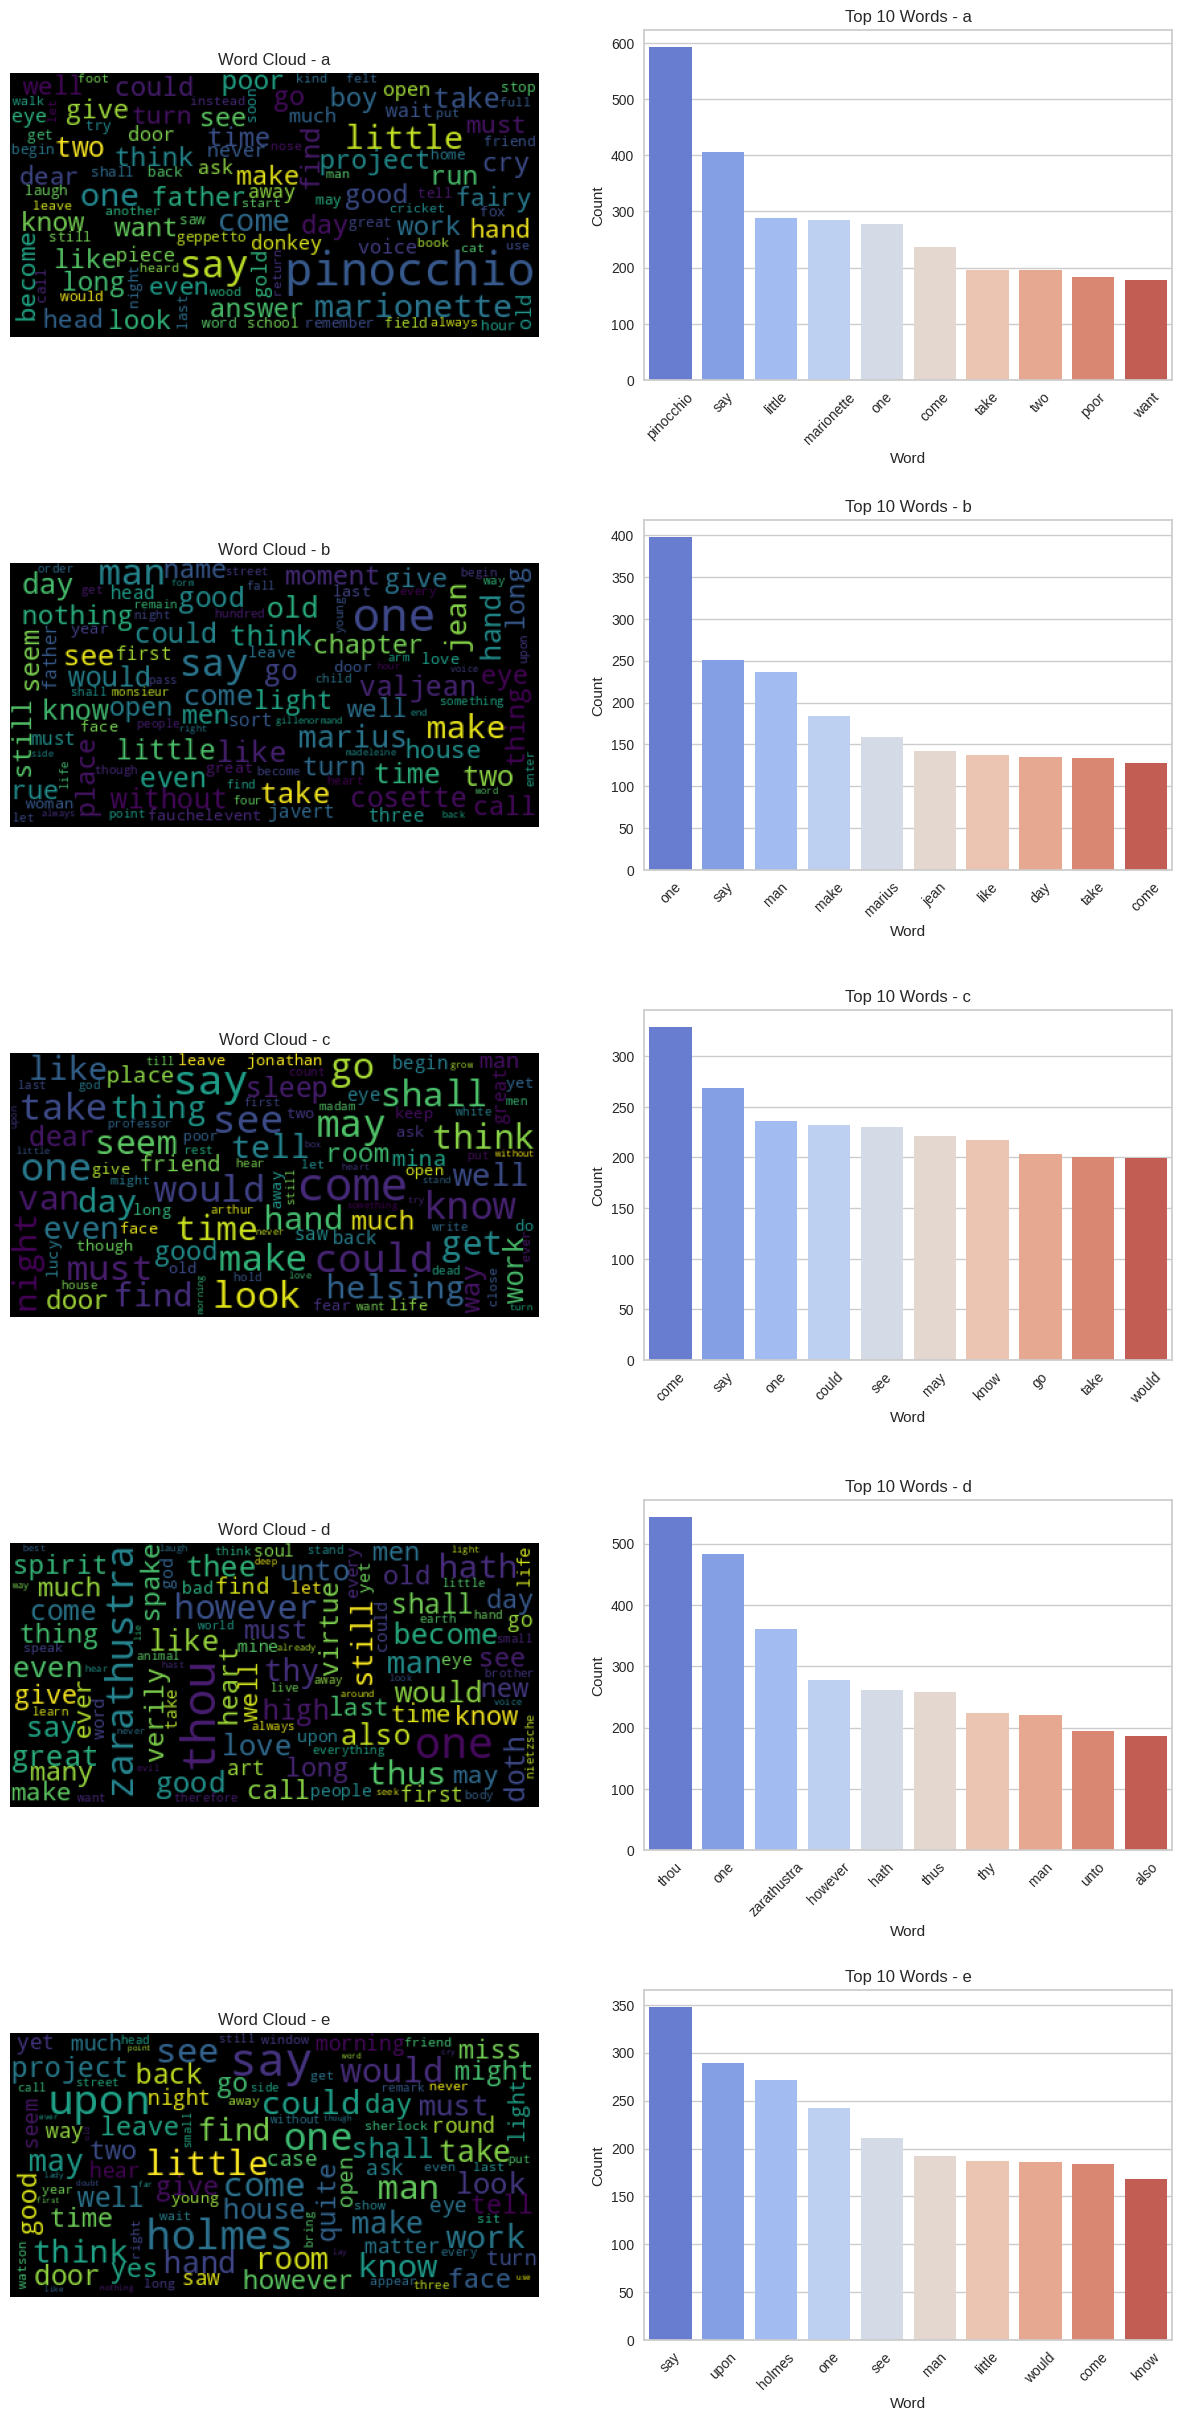

In [28]:
draw_chart(df , author_list )

# **Label encoding the true labels**

In [29]:
human_label=np.array(df.iloc[:,-1])

In [30]:
le = LabelEncoder()
human_label = le.fit_transform(human_label)

# Plotting BOW TSNE

In [31]:
data_bow=bow(df)

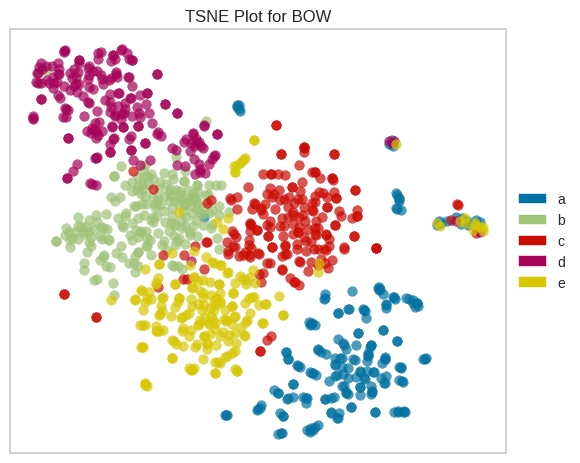

In [32]:
draw_TSNE(data_bow,"TSNE Plot for BOW")

# Plotting TF/IDF TSNE

In [33]:
data_TF=tf_idf(df)

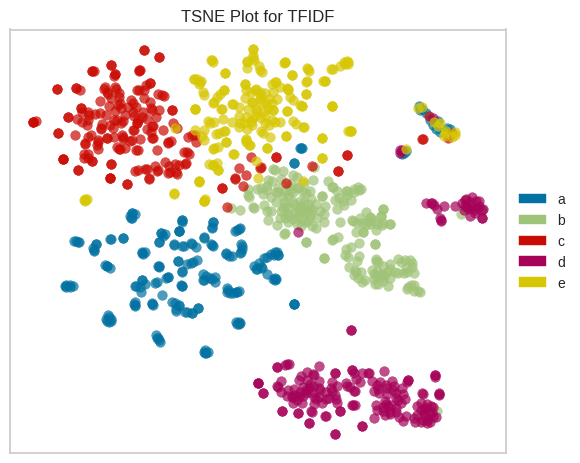

In [34]:
draw_TSNE(data_TF,"TSNE Plot for TFIDF")

# Initiate LDA

In [35]:
data_lda = apply_lda(df , "partitions" , 5)

# Applying KMEANS

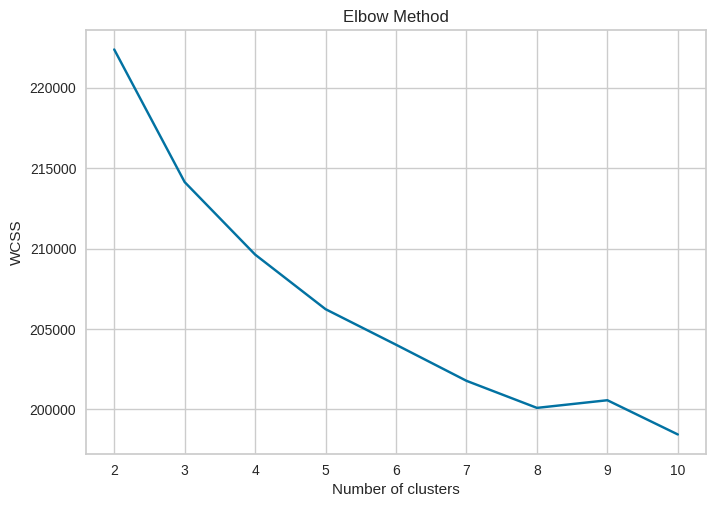

In [36]:
multi_km(data_bow)

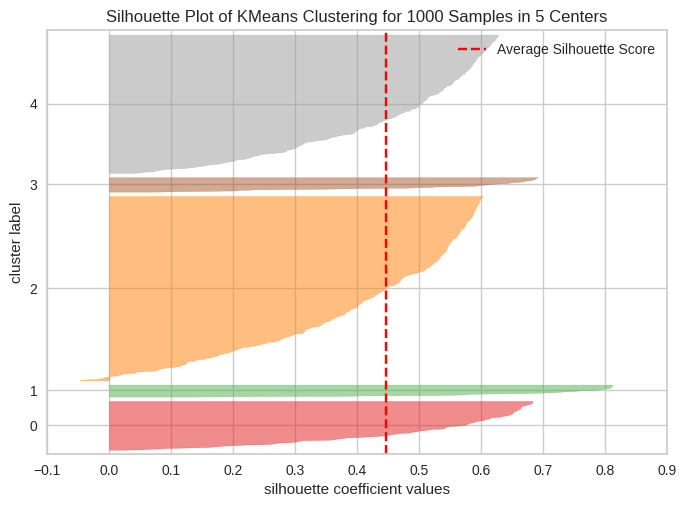

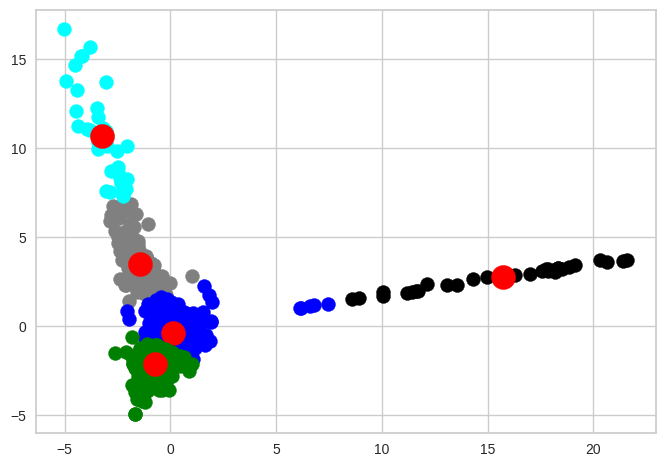

silhouette score :  44.573287420237236


In [37]:
km_labels_B_P , k_score_B_P = KMEANS(data_bow,5)

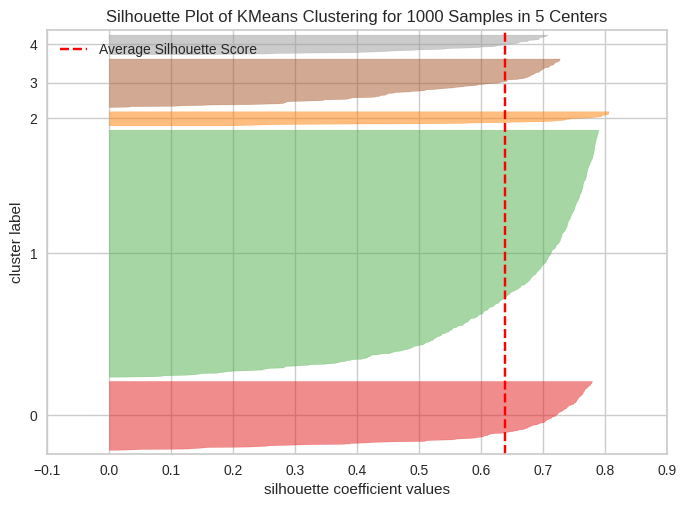

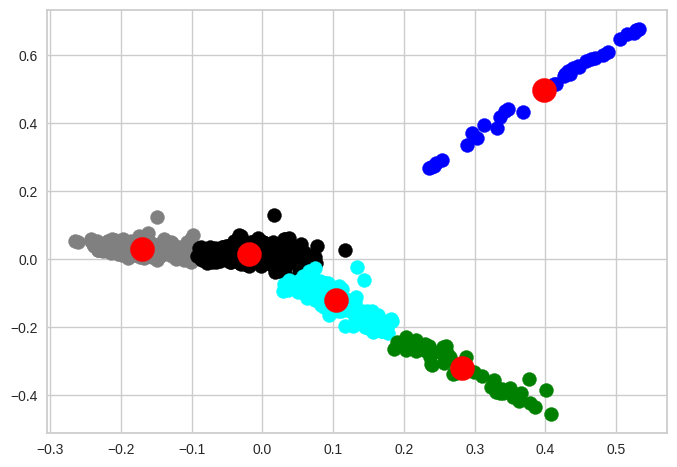

silhouette score :  63.772923899700984


In [38]:
km_labels_T_P , k_score_T_P = KMEANS(data_TF,5)


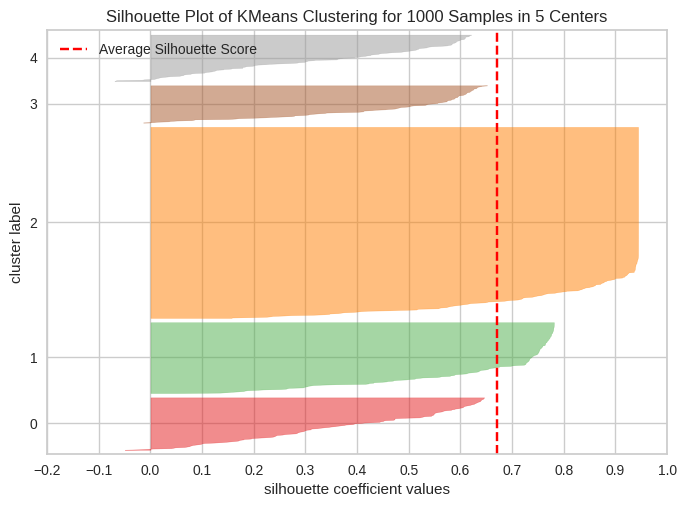

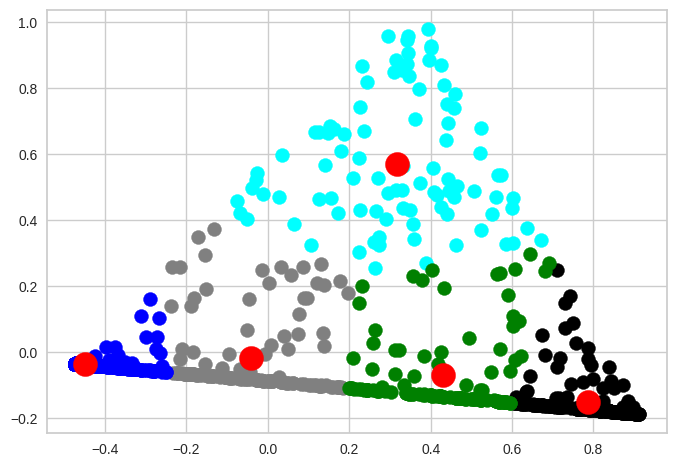

silhouette score :  67.08278882353149


In [39]:
km_labels_LDA , k_score_LDA = KMEANS(data_lda,5)

In [40]:

n_labels_km = map_for_kappa(km_labels_B_P , human_label)
cohen_kappa_score(km_labels_B_P,n_labels_km)

0.24

In [41]:

n_labels_km = map_for_kappa(km_labels_T_P , human_label)
cohen_kappa_score(km_labels_T_P,n_labels_km)

0.37124999999999997

In [42]:

n_labels_km = map_for_kappa(km_labels_LDA , human_label)
cohen_kappa_score(km_labels_LDA,n_labels_km)

0.02375000000000005

# Applying AGG

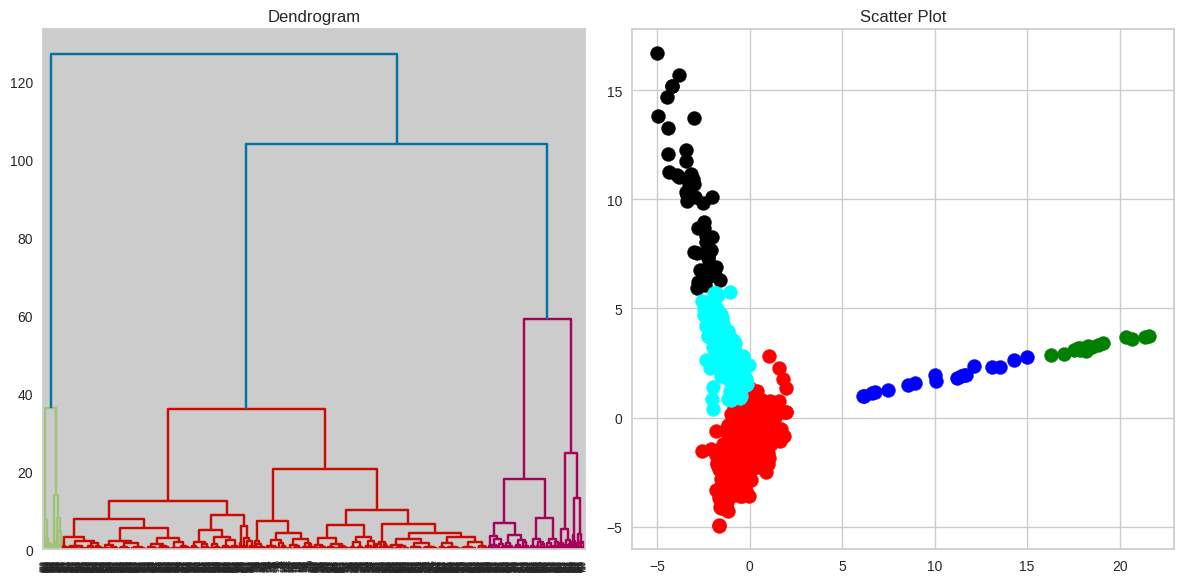

silhouette score :  61.16962497238789


In [43]:
hi_labels_B_P , agg_score_B_P = AGG(data_bow , 5  )

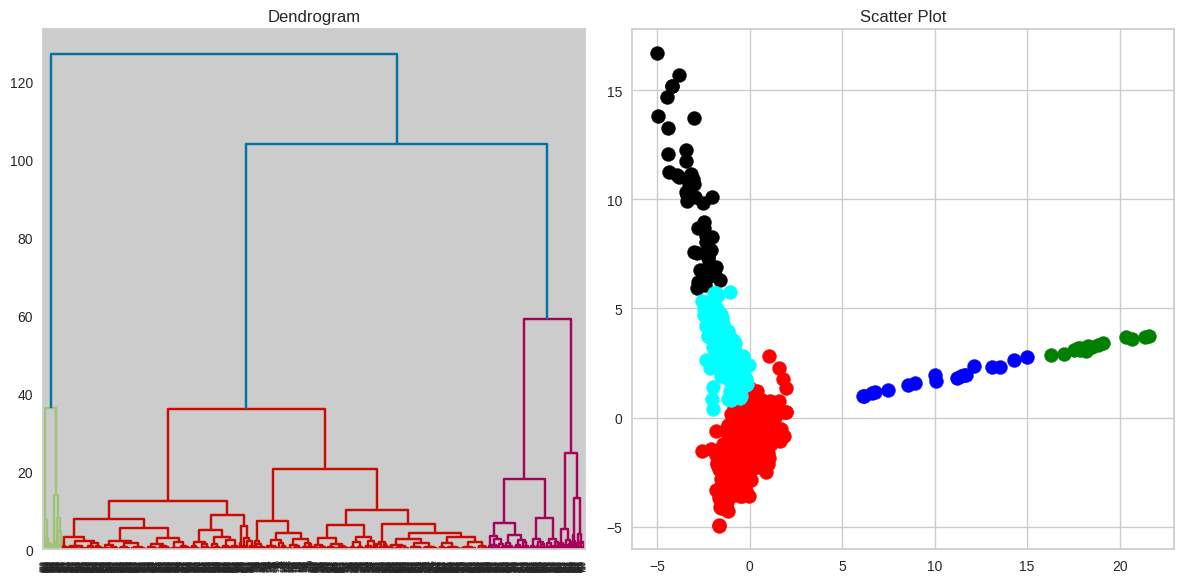

silhouette score :  61.16956996881902


In [44]:
hi_labels_T_P , agg_score_T_P = AGG(data_TF , 5)

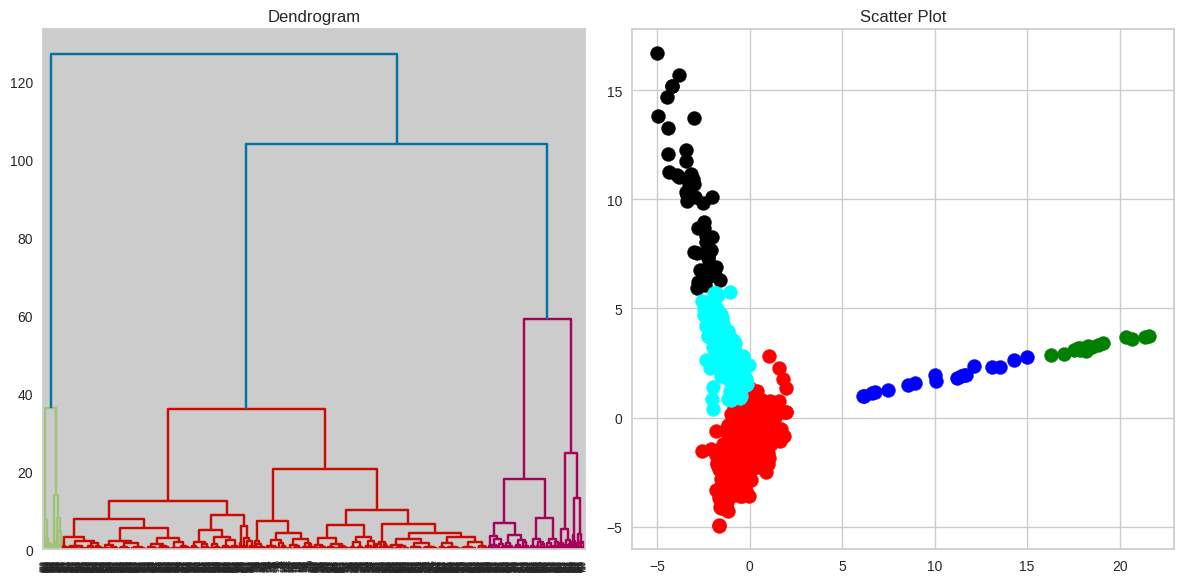

silhouette score :  61.169620155290296


In [45]:
hi_labels_LDA , agg_score_LDA = AGG(data_lda , 5)

In [46]:

n_labels_hi = map_for_kappa(hi_labels_B_P , human_label)
cohen_kappa_score(hi_labels_B_P,n_labels_hi)

0.08625000000000005

In [47]:

n_labels_hi = map_for_kappa(hi_labels_T_P , human_label)
cohen_kappa_score(hi_labels_T_P,n_labels_hi)

0.08625000000000005

In [48]:

n_labels_hi = map_for_kappa(hi_labels_LDA , human_label)
cohen_kappa_score(hi_labels_LDA,n_labels_hi)

0.08625000000000005

# Applying GMM

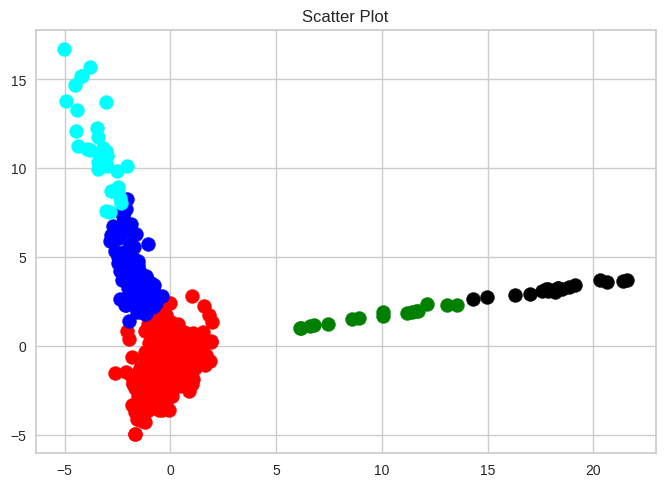

silhouette score :  65.19799718470077


In [49]:
GMM_label_B_P , gmm_score_B_P = GMM(data_bow,5)

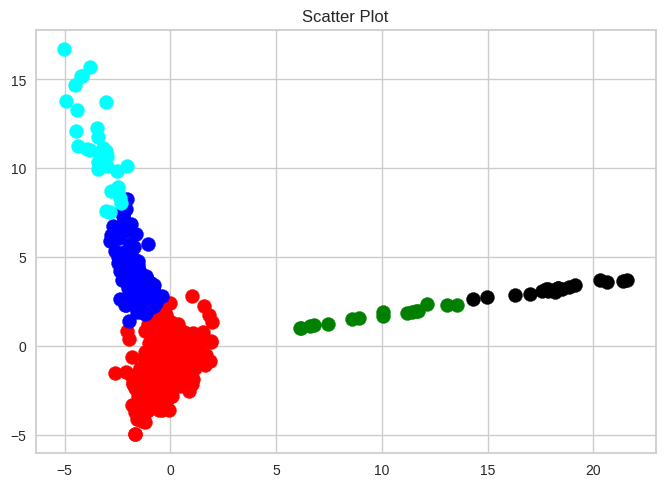

silhouette score :  65.19793038492557


In [50]:
GMM_label_T_P , gmm_score_T_P = GMM(data_TF,5)

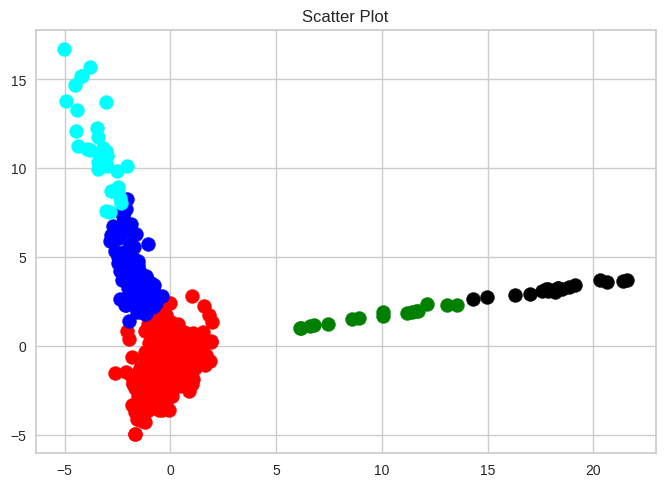

silhouette score :  65.19799920629808


In [51]:
GMM_label_LDA , gmm_score_LDA = GMM(data_lda,5)

In [52]:
n_labels_GMM = map_for_kappa(GMM_label_B_P , human_label)
cohen_kappa_score(GMM_label_B_P,n_labels_GMM)

0.15125

In [53]:
n_labels_GMM = map_for_kappa(GMM_label_T_P , human_label)
cohen_kappa_score(GMM_label_T_P,n_labels_GMM)

0.15125

In [54]:
n_labels_GMM = map_for_kappa(GMM_label_LDA , human_label)
cohen_kappa_score(GMM_label_LDA,n_labels_GMM)

0.15125

# Applying DBSCan


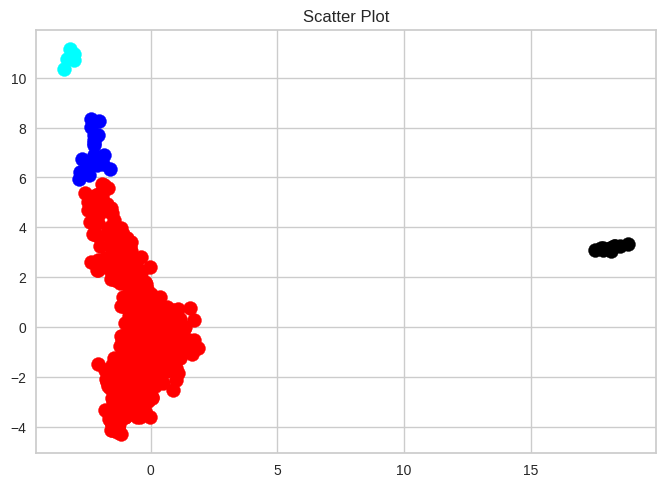

silhouette score :  59.99017761716875


In [55]:
dblabel_B_P , db_score_B_P = DBScan(data_bow)

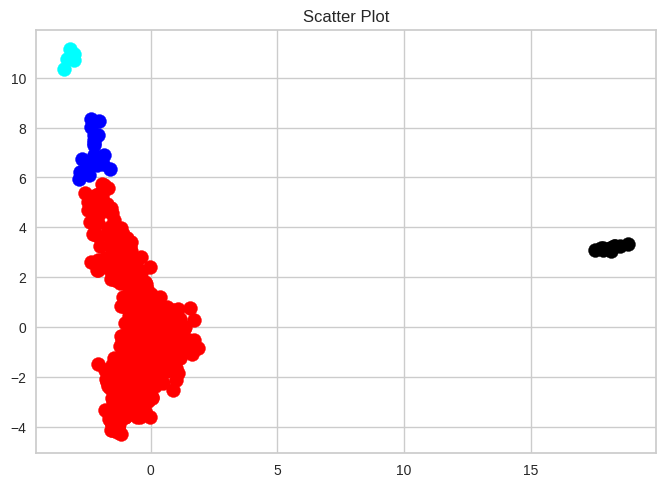

silhouette score :  59.990188740454705


In [56]:
dblabel_T_P , db_score_T_P = DBScan(data_TF)

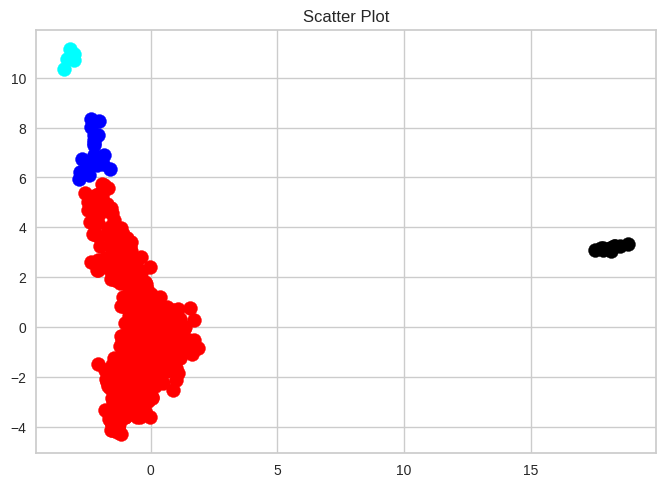

silhouette score :  59.99020416433273


In [57]:
dblabel_LDA , db_score_LDA = DBScan(data_lda)

In [58]:
n_labels_DB = map_for_kappa(dblabel_B_P , human_label)
cohen_kappa_score(dblabel_B_P,n_labels_DB)

0.04011813930593178

In [59]:
n_labels_DB = map_for_kappa(dblabel_T_P , human_label)
cohen_kappa_score(dblabel_T_P,n_labels_DB)

0.04011813930593178

In [60]:
n_labels_DB = map_for_kappa(dblabel_LDA , human_label)
cohen_kappa_score(dblabel_LDA,n_labels_DB)

0.04011813930593178

# test coherence  for LDA

In [61]:
get_coherence(data_bow,df.partitions)

0.761569707829174

# **Compare between BOW applying PCA**

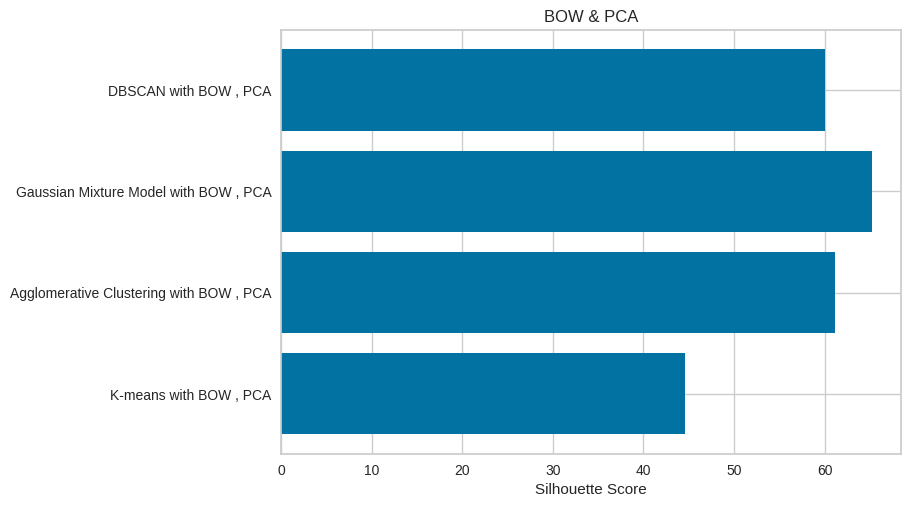

In [62]:
B_P_scores = [k_score_B_P , agg_score_B_P , gmm_score_B_P , db_score_B_P]
B_P_labels_list = ['K-means with BOW , PCA', 'Agglomerative Clustering with BOW , PCA', 'Gaussian Mixture Model with BOW , PCA', 'DBSCAN with BOW , PCA']
plotting(B_P_scores , B_P_labels_list , "BOW & PCA")

# **Compare between TFIDF applying PCA**

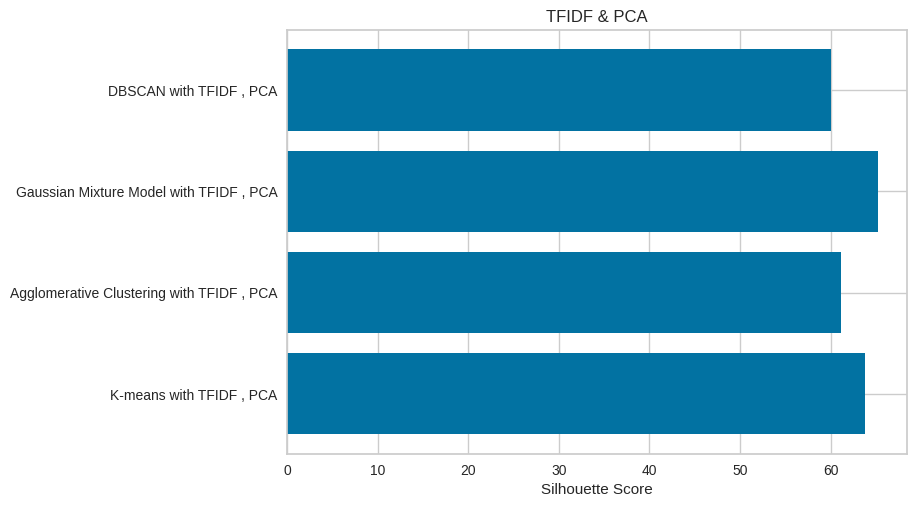

In [63]:
T_P_scores = [k_score_T_P , agg_score_T_P , gmm_score_T_P , db_score_T_P]
T_P_labels_list = ['K-means with TFIDF , PCA', 'Agglomerative Clustering with TFIDF , PCA', 'Gaussian Mixture Model with TFIDF , PCA', 'DBSCAN with TFIDF , PCA']
plotting(T_P_scores , T_P_labels_list , "TFIDF & PCA")

# **Compare between LDA applying PCA**

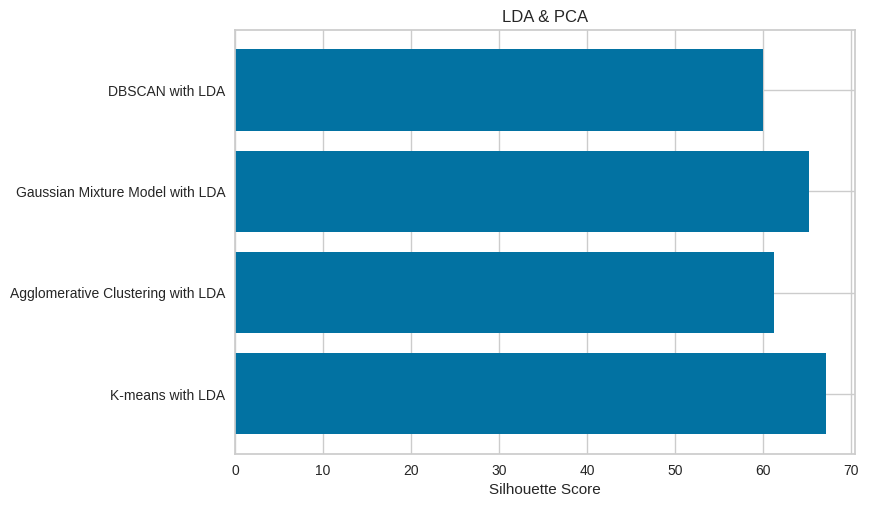

In [64]:
T_P_scores = [k_score_LDA , agg_score_LDA , gmm_score_LDA , db_score_LDA]
T_P_labels_list = ['K-means with LDA', 'Agglomerative Clustering with LDA', 'Gaussian Mixture Model with LDA', 'DBSCAN with LDA']
plotting(T_P_scores , T_P_labels_list , "LDA & PCA")

# **Champion Model**

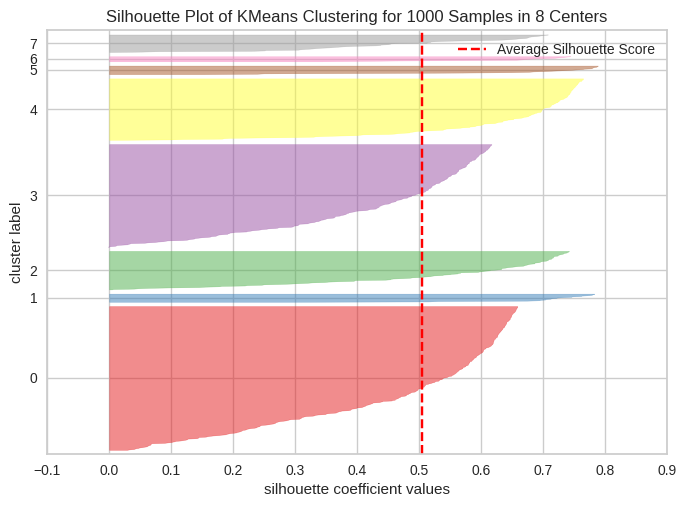

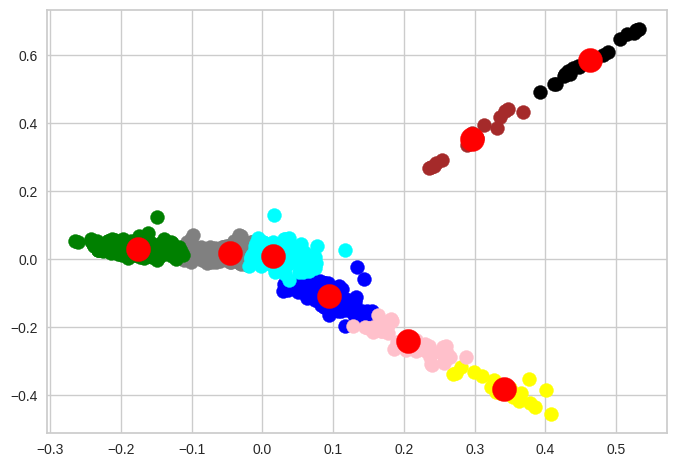

silhouette score :  50.41789372360913


In [78]:
km_labels_T_P , k_score_T_P = KMEANS(data_TF,8)


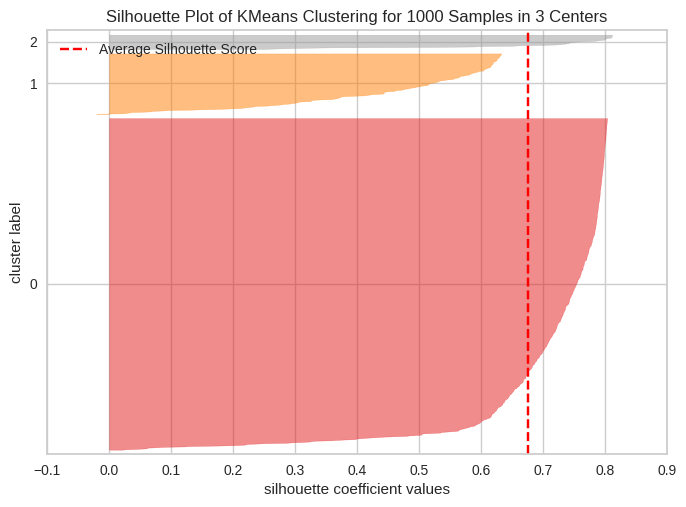

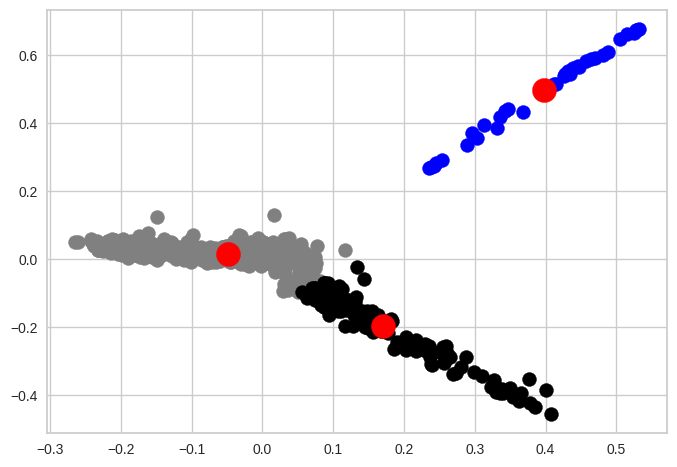

silhouette score :  67.56910951222073


In [77]:
km_labels_T_P , k_score_T_P = KMEANS(data_TF,3)
